# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
  1
  1
 -1
  1
  1
 -1
  1
 -1
  1
  ⋮
 -1
 -1
  1
  1
  1
 -1
 -1
  1
  1

### We create a function to visualize the data

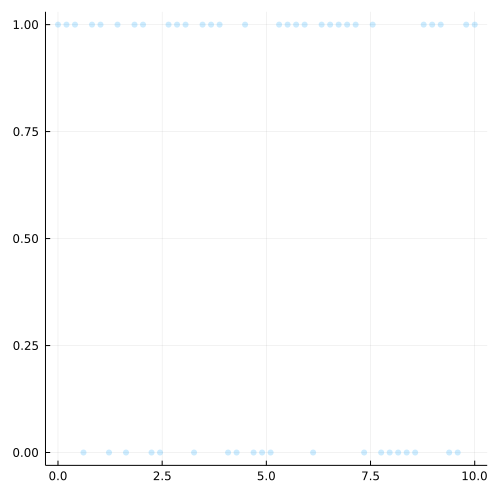

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.846822 seconds (1.85 M allocations: 98.333 MiB, 99.58% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [1.0271466263643159, 0.9956347820669178, 0.9496622331553038, 0.8927702896908418, 0.8314746913969792, 0.7731805051169259, 0.724740461264538, 0.690378930312271, 0.670580970069751, 0.6642396285096933  …  0.7469410074265961, 0.7410221400895604, 0.7014511951877405, 0.6492772584026039, 0.6120528057934371, 0.6102657391170221, 0.6450512304995139, 0.7018504050239962, 0.7645202238826783, 0.8227692125310658], θ = [0.23011547712333577, 0.23120873605267403, 0.23276406873054448, 0.23461973872216757, 0.23652753027764312, 0.23824772833278243, 0.23960307564185523, 0.2405218483557732, 0.241034629860692, 0.24119626603452227  …  0.23899048682353777, 0.23915524259899007, 0.24022974572068556, 0.24157257011465225, 0.24247733381292064, 0.24251962529721147, 0.2416775544264079, 0.24021914331006816, 0.238495087649

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:00
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:32
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:41
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:16
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:00
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:50
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:43
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:37
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:33
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:30
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:27
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:24
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.29218662852381316, 0.07125775354335151, 0.38434016148218103, 0.6919485366736098, 0.9643090255089491, 1.2320025986116683, 1.4424151170366786, 1.5970148610942767, 1.7018367715453464, 1.6649721874248187  …  0.28833719616002984, 0.19770975974437266, 0.10230036908746004, -0.005998588338144789, -0.12798164188476985, -0.2748803486506225, -0.4563260430242837, -0.6699416265751117, -0.9296034823698828, -1.1404319161314749]]
 [[0.10068490122448748, 0.18078058858241042, 0.2598815324586351, 0.32307649180073506, 0.3138310797635098, 0.2688502339872518, 0.17479781455899768, 0.1427966104224977, 0.10077690402688755, 0.12031469670560258  …  -0.1499744675843473, -0.23702438954241095, -0.2718214866107244, -0.28454990956267306, -0.2710864525638366, -0.14640020823642141, -0.028890818514810013, 0.1254395217630932, 0.32774821020619516, 0.532370333694239]]
 [[1.6765578377701775, 1.5018631475484698, 1.362291428943965, 1.1754024042507893, 1.0081293160819471, 0.8

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

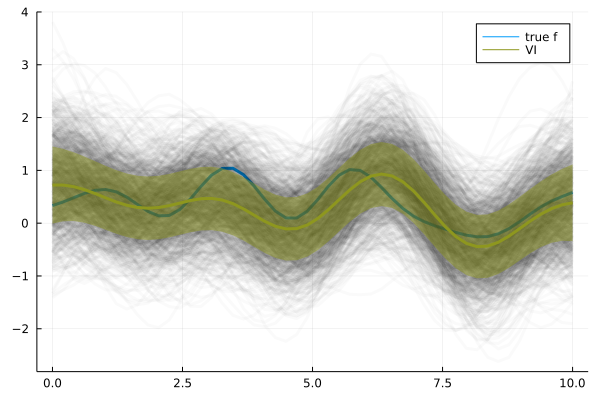

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

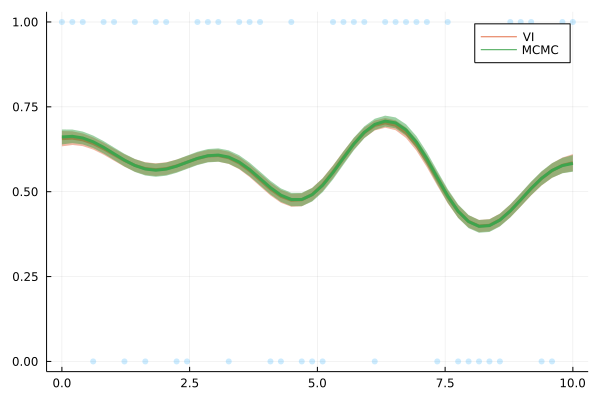

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*